# Dublin Bikes Data Analysis

In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

In [2]:
data1 = pd.read_csv('dublinbikes_20190401_20190701.csv')
data2 = pd.read_csv('dublinbikes_20190701_20191001.csv')
data3 = pd.read_csv('dublinbikes_20191001_20200101.csv')
data4 = pd.read_csv('dublinbikes_20200101_20200401.csv')
data1.sample(5)

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
97067,114,2019-04-03 10:20:03,2019-04-03 10:10:42,WILTON TERRACE (PARK),40.0,6.0,33.0,Open,Wilton Terrace (Park),53.333652,-6.248345
297951,19,2019-04-10 22:40:04,2019-04-10 22:31:24,HERBERT PLACE,30.0,30.0,0.0,Open,Herbert Place,53.334431,-6.245575
287993,99,2019-04-09 08:50:04,2019-04-09 08:43:30,CITY QUAY,30.0,16.0,14.0,Open,City Quay,53.346638,-6.246154
288122,99,2019-04-09 19:35:04,2019-04-09 19:25:55,CITY QUAY,30.0,30.0,0.0,Open,City Quay,53.346638,-6.246154
315498,81,2019-04-10 20:55:04,2019-04-10 20:51:37,ST. JAMES HOSPITAL (CENTRAL),40.0,17.0,23.0,Open,St. James Hospital (Central),53.339985,-6.295594


In [3]:
#merge data into one table
data = pd.concat([data1,data2, data3,data4])
data = data[data['STATUS'] == 'Open']
data = data[(data['LAST UPDATED'] >= '2019-07-01') & (data['LAST UPDATED'] < '2020-04-01')]
data = data[(data['LAST UPDATED'] < '2019-12-01') | (data['LAST UPDATED'] >= '2020-02-01')]

#remove rows where no update actually occurs
data = data.drop(['TIME'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)


#get date and time columns
data['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["LAST UPDATED"]]
data['LAST UPDATED'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['DATE'] = [dt.datetime.date(d) for d in data['DATETIME']] 
data['date_for_merge'] = data['DATETIME'].dt.round('H')

#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['DAY_NUMBER'] = data.DATETIME.dt.dayofweek
data['DAY_TYPE'] = np.where(data['DAY_NUMBER'] <= 4, 'Weekday', (np.where(data['DAY_NUMBER'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "


data["TIME_TYPE"] = data['DATETIME'].apply(bin_time)
data['HOUR'] = data['DATETIME'].dt.hour
data['MONTH'] = data['DATETIME'].dt.month
data['CLUSTER_GROUP'] = data['TIME_TYPE'] + data['DAY_TYPE']

data.sample(5)



,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
1214605,8,17:24:17,CUSTOM HOUSE QUAY,30.0,6.0,24.0,Open,Custom House Quay,53.347885,-6.248048,...,2019-11-08 17:00:00,0.800000,0,0,4,Weekday,4PM-7PM,17,11,4PM-7PM Weekday
278860,76,15:38:39,MARKET STREET SOUTH,38.0,29.0,8.0,Open,Market Street South,53.342297,-6.287661,...,2019-07-09 16:00:00,0.210526,0,0,1,Weekday,11AM-3PM,15,7,11AM-3PM Weekday
1562952,85,22:40:11,ROTHE ABBEY,35.0,19.0,16.0,Open,Rothe Abbey,53.338776,-6.303950,...,2019-08-18 23:00:00,0.457143,0,0,6,Sunday,8PM-11PM,22,8,8PM-11PM Sunday
81277,64,05:01:53,SANDWITH STREET,40.0,39.0,1.0,Open,Sandwith Street,53.345203,-6.247163,...,2019-10-03 05:00:00,0.025000,0,0,3,Weekday,Overnight,5,10,Overnight Weekday
916680,60,22:40:09,NORTH CIRCULAR ROAD,30.0,9.0,16.0,Open,North Circular Road,53.359623,-6.260348,...,2019-07-29 23:00:00,0.533333,0,0,0,Weekday,8PM-11PM,22,7,8PM-11PM Weekday
1821683,67,14:18:22,THE POINT,40.0,34.0,6.0,Open,The Point,53.346867,-6.230852,...,2019-11-27 14:00:00,0.150000,0,0,2,Weekday,11AM-3PM,14,11,11AM-3PM Weekday
315891,93,05:32:17,HEUSTON STATION (CENTRAL),40.0,11.0,29.0,Open,Heuston Station (Central),53.346603,-6.296924,...,2019-07-10 06:00:00,0.725000,0,0,2,Weekday,Overnight,5,7,Overnight Weekday
1349112,34,20:19:51,PORTOBELLO HARBOUR,30.0,10.0,20.0,Open,Portobello Harbour,53.330360,-6.265163,...,2019-11-12 20:00:00,0.666667,0,0,1,Weekday,8PM-11PM,20,11,8PM-11PM Weekday
976520,45,17:24:52,DEVERELL PLACE,30.0,19.0,11.0,Open,Deverell Place,53.351463,-6.255265,...,2019-07-31 17:00:00,0.366667,0,0,2,Weekday,4PM-7PM,17,7,4PM-7PM Weekday
1325521,114,23:40:46,WILTON TERRACE (PARK),40.0,40.0,0.0,Open,Wilton Terrace (Park),53.333652,-6.248345,...,2020-03-04 00:00:00,0.000000,1,0,1,Weekday,Overnight,23,3,Overnight Weekday


In [4]:
### Prepare Weather Data

weather = pd.read_csv('hly175.csv')
weather['date'] = [dt.datetime.strptime(d, "%m/%d/%Y %H:%M") for d in weather['date'] ]
weather['date_for_merge'] = weather['date'].dt.round('H')
weather = weather[(weather['date'] >= '2019-04-01') & (weather['date'] < '2020-04-02')]
weather = weather[['date_for_merge', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']]
weather['rain'] = weather['rain'].astype(float)
weather['temp'] = weather['temp'].astype(float)

#add binary variables to note wet/dry weather and hot or not days (temperature)
weather['dry'] = np.where(weather['rain'] > 0.0, 1, 0)
weather['warm'] = np.where(weather['temp'] > 18.0, 1, 0)
weather.sample(5)


,date_for_merge,rain,temp,wetb,dewpt,vappr,rhum,msl,dry,warm
118062,2020-03-06 07:00:00,0.0,0.4,0.3,0,6.1,97,1001.1,0,0
116356,2019-12-26 05:00:00,0.0,7.4,6.1,4.4,8.4,81,1009.4,0,0
114632,2019-10-15 09:00:00,0.0,11.2,11,10.8,13,97,1001.7,0,0
117787,2020-02-23 20:00:00,0.0,4.9,3.4,1.1,6.6,76,1021,0,0
112103,2019-07-02 00:00:00,0.0,10.5,9.4,8.3,10.9,86,1027.2,0,0


In [5]:
#merge weather with bikes data
merged_data = pd.merge(data, weather, on = 'date_for_merge', how = 'left')

# identify bike arrivals and bike departures
merged_data['BIKE_ARR_DEP'] = merged_data.groupby('STATION ID')['AVAILABLE BIKE STANDS'].diff(-1)
merged_data['BIKE_ARR'] = np.where(merged_data['BIKE_ARR_DEP'] > 0, merged_data['BIKE_ARR_DEP'], 0)
merged_data['BIKE_DEP'] = np.where(merged_data['BIKE_ARR_DEP'] < 0, merged_data['BIKE_ARR_DEP'], 0)
merged_data['ACTIVITY_TYPE'] = np.where(abs(merged_data['BIKE_ARR_DEP']) >= 10, "REBALANCING", "RENTAL")
merged_data['IMBALANCED'] = np.where(merged_data['OCCUPANCY_PCT'] < .1, 1, 
                                   np.where(merged_data['OCCUPANCY_PCT'] > .9, 1,0 ))

# Identify days with rebalancing
merged_data['REBALANCING'] = np.where(merged_data['ACTIVITY_TYPE'] == 'REBALANCING', 1,0)
merged_data['JOIN_ON'] = merged_data['STATION ID'].apply(str)  + (merged_data['DATE']).apply(str) 
join_table= merged_data.groupby(['JOIN_ON'])['REBALANCING'].sum()
merged_data = merged_data.drop(['REBALANCING'], axis = 1)
join_table = join_table.to_frame()
join_table =join_table.reset_index()
merged_data = pd.merge(merged_data, join_table, on = 'JOIN_ON', how = 'left')
merged_data = merged_data.drop(['JOIN_ON'], axis = 1)

merged_data.sample(5)

4154564
4154564


,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,rhum,msl,dry,warm,BIKE_ARR_DEP,BIKE_ARR,BIKE_DEP,ACTIVITY_TYPE,IMBALANCED,REBALANCING
4089510,9,19:30:51,EXCHEQUER STREET,24.0,23.0,1.0,Open,Exchequer Street,53.343033,-6.263578,...,63,1040.4,0,0,0.0,0.0,0.0,RENTAL,1,0
2170629,53,03:17:05,NEWMAN HOUSE,40.0,40.0,0.0,Open,Newman House,53.337132,-6.260590,...,95,995.7,1,0,0.0,0.0,0.0,RENTAL,1,1
3648605,50,13:50:32,GEORGES LANE,40.0,39.0,1.0,Open,George's Lane,53.350231,-6.279696,...,50,1004,0,0,-1.0,0.0,-1.0,RENTAL,1,0
3169431,48,17:49:44,EXCISE WALK,40.0,4.0,36.0,Open,Excise Walk,53.347778,-6.244239,...,85,1000.8,0,0,-3.0,0.0,-3.0,RENTAL,0,0
1953103,75,04:31:34,JAMES STREET,40.0,2.0,38.0,Open,James Street,53.343456,-6.287409,...,98,1010.4,0,0,-1.0,0.0,-1.0,RENTAL,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646217,50,23:19:19,GEORGES LANE,40.0,0.0,40.0,Open,George's Lane,53.350231,-6.279696,...,91,1021,0,0,0.0,0.0,0.0,RENTAL,1,0
1301723,7,22:48:18,HIGH STREET,29.0,13.0,16.0,Open,High Street,53.343567,-6.275071,...,91,1014.6,0,0,-2.0,0.0,-2.0,RENTAL,0,1
3243008,48,04:13:10,EXCISE WALK,40.0,27.0,13.0,Open,Excise Walk,53.347778,-6.244239,...,79,1000.4,0,0,0.0,0.0,0.0,RENTAL,0,0
2613804,12,08:15:03,ECCLES STREET,20.0,20.0,0.0,Open,Eccles Street,53.359245,-6.269779,...,85,1012.8,0,0,0.0,0.0,0.0,RENTAL,1,0


### Time Clusters

In [6]:
#group data into clusters
clustering_df = merged_data[['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'DAY_TYPE', 'TIME_TYPE', 'OCCUPANCY_PCT','CLUSTER_GROUP']]
clustering_df = clustering_df.groupby(['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'CLUSTER_GROUP'],as_index=False)['OCCUPANCY_PCT'].mean()
clustering_df  = clustering_df.set_index('STATION ID')

#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['NAME', 'STATION ID','LATITUDE', 'LONGITUDE'] , columns=['CLUSTER_GROUP'], values='OCCUPANCY_PCT')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('NAME')
clustering_df = clustering_df.dropna()

clustering_df.sample(5)

CLUSTER_GROUP,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday
NAME,,,,,,,,,,,,,,,,,,
AVONDALE ROAD,108,53.359406,-6.276142,0.159102,0.126197,0.107060,0.208063,0.183721,0.247766,0.279970,0.168737,0.154918,0.206872,0.252699,0.369088,0.390925,0.243118,0.421789
BARROW STREET,70,53.341656,-6.236198,0.457221,0.129602,0.703599,0.091699,0.502551,0.163900,0.593277,0.249084,0.730308,0.119338,0.753040,0.218540,0.287356,0.247592,0.315751
BENSON STREET,90,53.344154,-6.233451,0.178727,0.142477,0.655158,0.125685,0.142831,0.091801,0.225119,0.190721,0.735708,0.134686,0.166334,0.059702,0.093759,0.161444,0.109268
BLACKHALL PLACE,88,53.348801,-6.281637,0.375960,0.442651,0.131210,0.439610,0.480735,0.409125,0.559444,0.566730,0.237267,0.556918,0.625755,0.760816,0.730187,0.657854,0.828303
BLESSINGTON STREET,2,53.356770,-6.268140,0.177049,0.079175,0.118073,0.170406,0.188239,0.248699,0.164333,0.129490,0.161376,0.206522,0.278690,0.482975,0.420940,0.282905,0.545053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WILTON TERRACE,39,53.332382,-6.252717,0.182339,0.274832,0.476939,0.268946,0.339717,0.178934,0.235636,0.363081,0.376225,0.337126,0.385714,0.169892,0.189921,0.288643,0.183609
WILTON TERRACE (PARK),114,53.333652,-6.248345,0.184591,0.297848,0.677884,0.176332,0.246790,0.082237,0.131170,0.251960,0.591142,0.167531,0.222931,0.041147,0.060603,0.171386,0.073972
WOLFE TONE STREET,77,53.348873,-6.267459,0.785582,0.790810,0.174785,0.803063,0.728321,0.183086,0.394298,0.692944,0.127001,0.741134,0.632989,0.194274,0.401656,0.700093,0.192410


### K-Means Clustering Analysis

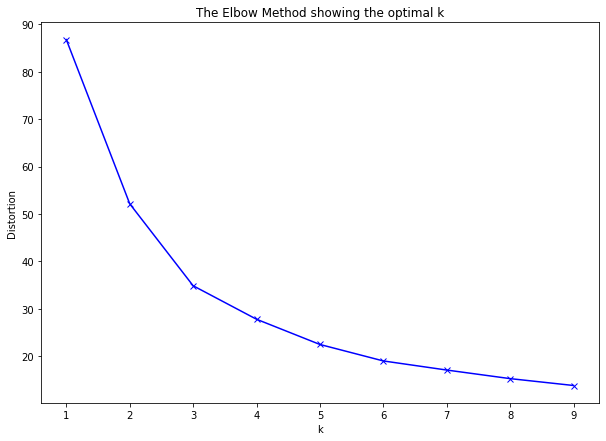

In [7]:
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [8]:
#clustering algo
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
KM = KMeans(n_clusters=5) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()
locations.head(5)

CLUSTER_GROUP,NAME,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday,Cluster
0,AVONDALE ROAD,108,53.359406,-6.276142,0.159102,0.126197,0.107060,0.208063,0.183721,0.247766,0.279970,0.168737,0.154918,0.206872,0.252699,0.369088,0.390925,0.243118,0.421789,4
1,BARROW STREET,70,53.341656,-6.236198,0.457221,0.129602,0.703599,0.091699,0.502551,0.163900,0.593277,0.249084,0.730308,0.119338,0.753040,0.218540,0.287356,0.247592,0.315751,2
2,BENSON STREET,90,53.344154,-6.233451,0.178727,0.142477,0.655158,0.125685,0.142831,0.091801,0.225119,0.190721,0.735708,0.134686,0.166334,0.059702,0.093759,0.161444,0.109268,2
3,BLACKHALL PLACE,88,53.348801,-6.281637,0.375960,0.442651,0.131210,0.439610,0.480735,0.409125,0.559444,0.566730,0.237267,0.556918,0.625755,0.760816,0.730187,0.657854,0.828303,3
4,BLESSINGTON STREET,2,53.356770,-6.268140,0.177049,0.079175,0.118073,0.170406,0.188239,0.248699,0.164333,0.129490,0.161376,0.206522,0.278690,0.482975,0.420940,0.282905,0.545053,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,WILTON TERRACE,39,53.332382,-6.252717,0.182339,0.274832,0.476939,0.268946,0.339717,0.178934,0.235636,0.363081,0.376225,0.337126,0.385714,0.169892,0.189921,0.288643,0.183609,2
109,WILTON TERRACE (PARK),114,53.333652,-6.248345,0.184591,0.297848,0.677884,0.176332,0.246790,0.082237,0.131170,0.251960,0.591142,0.167531,0.222931,0.041147,0.060603,0.171386,0.073972,2
110,WOLFE TONE STREET,77,53.348873,-6.267459,0.785582,0.790810,0.174785,0.803063,0.728321,0.183086,0.394298,0.692944,0.127001,0.741134,0.632989,0.194274,0.401656,0.700093,0.192410,1
111,YORK STREET EAST,52,53.338757,-6.262003,0.726314,0.787236,0.588127,0.673442,0.689318,0.270586,0.479422,0.699660,0.522576,0.620743,0.515885,0.117229,0.240605,0.561033,0.143291,1


In [9]:
colordict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.5)
for LATITUDE, LONGITUDE, Cluster in zip(locations['LATITUDE'],locations['LONGITUDE'], locations['Cluster']):
    folium.CircleMarker(
        [LATITUDE, LONGITUDE],
        color = 'b',
        radius = 8,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map
    

In [10]:
#merge clusters back into main dataset

merged_with_clusters = merged_data
cluster_output = locations[['STATION ID', 'Cluster']]
cluster_output.drop_duplicates(keep = 'first', inplace = True)
del merged_data
merged_with_clusters = pd.merge (merged_with_clusters, cluster_output, on = 'STATION ID', how = 'left')
merged_with_clusters['BIKE_ARR_DEP_ABS'] = abs(merged_with_clusters['BIKE_ARR_DEP'])
merged_with_clusters.sample(5)

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,dry,warm,BIKE_ARR_DEP,BIKE_ARR,BIKE_DEP,ACTIVITY_TYPE,IMBALANCED,REBALANCING,Cluster,BIKE_ARR_DEP_ABS
0,2,00:02:22,BLESSINGTON STREET,20.0,18.0,2.0,Open,Blessington Street,53.356770,-6.268140,...,0,0,0.0,0.0,0.0,RENTAL,0,1,4,0.0
1,2,00:12:31,BLESSINGTON STREET,20.0,18.0,2.0,Open,Blessington Street,53.356770,-6.268140,...,0,0,0.0,0.0,0.0,RENTAL,0,1,4,0.0
2,2,00:22:41,BLESSINGTON STREET,20.0,18.0,2.0,Open,Blessington Street,53.356770,-6.268140,...,0,0,0.0,0.0,0.0,RENTAL,0,1,4,0.0
3,2,00:32:50,BLESSINGTON STREET,20.0,18.0,2.0,Open,Blessington Street,53.356770,-6.268140,...,1,0,0.0,0.0,0.0,RENTAL,0,1,4,0.0
4,2,00:42:59,BLESSINGTON STREET,20.0,18.0,2.0,Open,Blessington Street,53.356770,-6.268140,...,1,0,0.0,0.0,0.0,RENTAL,0,1,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154559,117,23:12:21,HANOVER QUAY EAST,40.0,40.0,0.0,Open,Hanover Quay East,53.343655,-6.231755,...,0,0,0.0,0.0,0.0,RENTAL,1,0,2,0.0
4154560,117,23:22:30,HANOVER QUAY EAST,40.0,40.0,0.0,Open,Hanover Quay East,53.343655,-6.231755,...,0,0,0.0,0.0,0.0,RENTAL,1,0,2,0.0
4154561,117,23:32:39,HANOVER QUAY EAST,40.0,40.0,0.0,Open,Hanover Quay East,53.343655,-6.231755,...,0,0,0.0,0.0,0.0,RENTAL,1,0,2,0.0
4154562,117,23:42:48,HANOVER QUAY EAST,40.0,40.0,0.0,Open,Hanover Quay East,53.343655,-6.231755,...,0,0,0.0,0.0,0.0,RENTAL,1,0,2,0.0


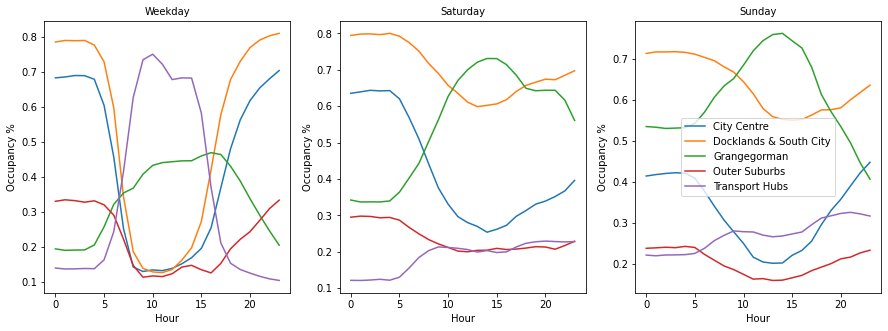

In [11]:
linechart_data = merged_with_clusters[['DAY_TYPE', 'Cluster', 'HOUR', 'OCCUPANCY_PCT']]
linechart_data['Cluster'] = np.where(linechart_data['Cluster'] == 0, 'City Centre',
                                    np.where(linechart_data['Cluster'] == 1, 'Grangegorman',
                                            np.where(linechart_data['Cluster'] == 2, 'Transport Hubs',
                                                    np.where(linechart_data['Cluster'] == 3, 'Docklands & South City', 'Outer Suburbs'))))

#Weekday
linechart_data_weekday = linechart_data[linechart_data['DAY_TYPE'] == 'Weekday']
linechart_data_weekday = linechart_data_weekday.groupby(['HOUR', 'Cluster'])['OCCUPANCY_PCT'].mean()
linechart_data_weekday  = linechart_data_weekday.reset_index()
y1 = linechart_data_weekday['OCCUPANCY_PCT'].values
x1 = linechart_data_weekday['HOUR'].values
labels1 = linechart_data_weekday['Cluster'].values
colours1 = linechart_data_weekday['Cluster'].values
df1 = pd.DataFrame(dict(x=x1, y=y1, label=labels1))
groups1 = df1.groupby('label')

#Saturday
linechart_data_saturday = linechart_data[linechart_data['DAY_TYPE'] == 'Saturday']
linechart_data_saturday = linechart_data_saturday.groupby(['HOUR', 'Cluster'])['OCCUPANCY_PCT'].mean()
linechart_data_saturday  = linechart_data_saturday.reset_index()
y2 = linechart_data_saturday['OCCUPANCY_PCT'].values
x2 = linechart_data_saturday['HOUR'].values
labels2 = linechart_data_saturday['Cluster'].values
colours2 = linechart_data_saturday['Cluster'].values
df2 = pd.DataFrame(dict(x=x2, y=y2, label=labels2))
groups2 = df2.groupby('label')

#Sunday
linechart_data_sunday = linechart_data[linechart_data['DAY_TYPE'] == 'Sunday']
linechart_data_sunday = linechart_data_sunday.groupby(['HOUR', 'Cluster'])['OCCUPANCY_PCT'].mean()
linechart_data_sunday  = linechart_data_sunday.reset_index()
y3 = linechart_data_sunday['OCCUPANCY_PCT'].values
x3 = linechart_data_sunday['HOUR'].values
labels3 = linechart_data_sunday['Cluster'].values
colours3 = linechart_data_sunday['Cluster'].values
df3 = pd.DataFrame(dict(x=x3, y=y3, label=labels3))
groups3 = df3.groupby('label')

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for name, group in groups1:
    axs[0].plot(group.x, group.y, label=name)
    axs[0].set_title('Weekday')
    axs[0].set_xlabel('Hour')
    axs[0].set_ylabel('Occupancy %')
    #fig.suptitle('This is a somewhat long figure title', fontsize=16)

for name, group in groups2:
    axs[1].plot(group.x, group.y, label=name)
    axs[1].set_title('Saturday')
    axs[1].set_xlabel('Hour')
    axs[1].set_ylabel('Occupancy %')
    

for name, group in groups3:
    axs[2].plot(group.x, group.y, label=name)
    axs[2].set_title('Sunday')
    axs[2].set_xlabel('Hour')
    axs[2].set_ylabel('Occupancy %')
    axs[2].legend()

plt.show()

In [12]:
# Impact of Stations
join_table= merged_with_clusters.groupby(['STATION ID','NAME', 'DATE']).agg(rain=('rain', 'sum'), TOTAL_CHANGES=('BIKE_ARR_DEP_ABS', 'sum'))
join_table =join_table.reset_index()
join_table['WET/DRY DAY'] = np.where(join_table['rain'] > 3, "Wet", "Dry")
join_table = join_table.drop(['rain'], axis = 1)
join_table =join_table.reset_index()
merged_with_clusters_wetdry = pd.merge(merged_with_clusters, join_table, on = ['STATION ID', 'NAME', 'DATE'], how = 'left')

wetday_df= merged_with_clusters_wetdry.groupby(['STATION ID', 'NAME', 'WET/DRY DAY']).agg(AVG_CHANGES=('TOTAL_CHANGES', 'mean'))
wetday_df =wetday_df.reset_index()
difference_df = wetday_df.pivot(index=['NAME'], columns='WET/DRY DAY', values='AVG_CHANGES').reset_index()
difference_df['Change'] = difference_df['Dry'] - difference_df['Wet']
difference_df.sort_values(by = 'Change', ascending=False).head(30)

4154564
4154564


,STATION ID,NAME,WET/DRY DAY,AVG_CHANGES
0,2,BLESSINGTON STREET,Dry,78.941564
1,2,BLESSINGTON STREET,Wet,75.793642
2,3,BOLTON STREET,Dry,111.753690
3,3,BOLTON STREET,Wet,110.320338
4,4,GREEK STREET,Dry,87.906267
...,...,...,...,...
221,115,KILLARNEY STREET,Wet,131.547406
222,116,BROADSTONE,Dry,11.640736
223,116,BROADSTONE,Wet,11.240880
224,117,HANOVER QUAY EAST,Dry,34.425930


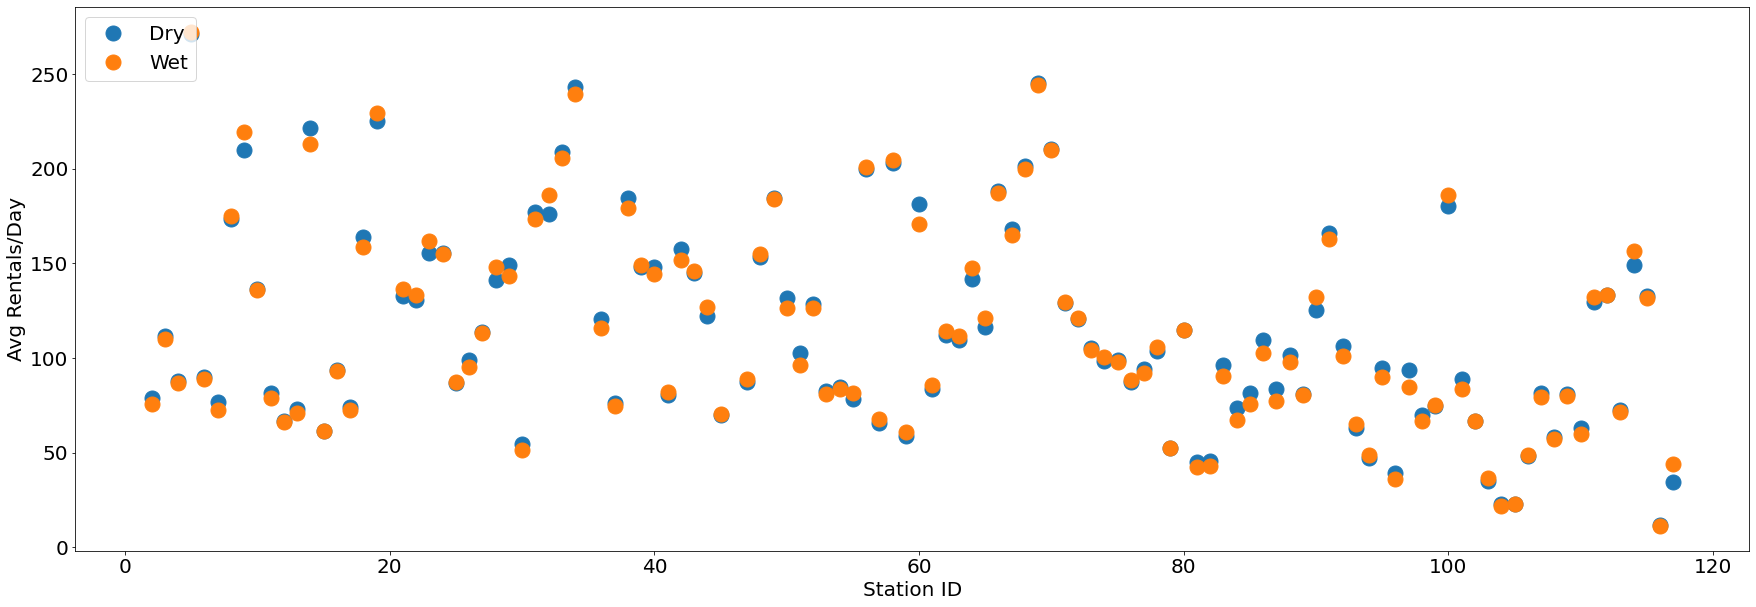

In [15]:
import pandas as pd
y = wetday_df['AVG_CHANGES'].values
x = wetday_df['STATION ID'].values
labels = wetday_df['WET/DRY DAY'].values
colours = wetday_df['WET/DRY DAY'].values
df = pd.DataFrame(dict(x=x, y=y, label=labels))
groups = df.groupby('label')

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y,  marker='o',  linestyle='', ms=15, label=name)
ax.legend(numpoints=1, loc='upper left')
plt.xlabel("Station ID")
plt.ylabel("Avg Rentals/Day")
plt.show()

### ML Occupancy Percentage Classifier

In [16]:
ml_classifier_data = merged_with_clusters[merged_with_clusters['REBALANCING'] < 1] #exclude days where rebalancing took place
ml_classifier_data = ml_classifier_data[['STATION ID', 'OCCUPANCY_PCT' , 'dry', 'warm', 'DAY_NUMBER', 'HOUR', 'MONTH']]


def bin_occupancy(x):
    if x < 0.1:
        return 0
    elif x < 0.1:
        return 0.1
    elif x < 0.2:
        return 0.1
    elif x < 0.3:
        return 0.1
    elif x < 0.4:
        return 0.1
    elif x < 0.5:
        return 0.1
    elif x < 0.6:
        return 0.1
    elif x < 0.7:
        return 0.1
    elif x < 0.8:
        return 0.1
    else:
        return 0.2

ml_classifier_data["OCC_GROUP"] = ml_classifier_data['OCCUPANCY_PCT'].apply(bin_occupancy)
ml_classifier_data["OCC_GROUP"] = ml_classifier_data["OCC_GROUP"] * 10
ml_classifier_data["OCC_GROUP"] = ml_classifier_data["OCC_GROUP"].astype(int)
ml_classifier_data.dropna(inplace = True)
msk = np.random.rand(len(ml_classifier_data)) < 0.8
train = ml_classifier_data[msk]
test = ml_classifier_data[~msk]
print(len(train))
print(len(test))

X_train = train.drop(['OCCUPANCY_PCT', "OCC_GROUP"], axis = 1)
X_test = test.drop(['OCCUPANCY_PCT', "OCC_GROUP"], axis = 1)
Y_train = train[["OCC_GROUP"]] 
Y_test = test[["OCC_GROUP"]]

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,Y_train)

Y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

#pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
print(sklearn.metrics.classification_report(Y_test,Y_pred))

2461648
615672
Accuracy: 0.7880381112020687
              precision    recall  f1-score   support

           0       0.77      0.72      0.74    169365
           1       0.80      0.85      0.82    348582
           2       0.77      0.71      0.74     97725

    accuracy                           0.79    615672
   macro avg       0.78      0.76      0.77    615672
weighted avg       0.79      0.79      0.79    615672



No handles with labels found to put in legend.


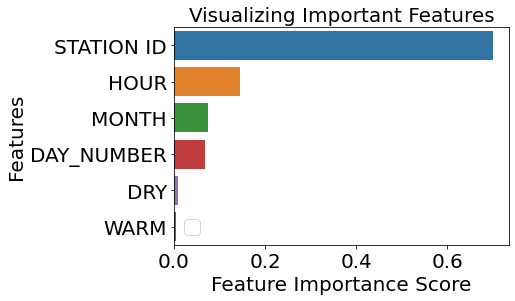

In [17]:
## show feature importances 

feature_imp = pd.Series(clf.feature_importances_,index=['STATION ID','DRY', 'WARM', 'DAY_NUMBER', 'HOUR', 'MONTH']).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()